In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# **1) Importing Libraries**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# Sklearn
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS

from sklearn.metrics import *
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler

#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier as XGBC
import xgboost as xgb

#catboost
from catboost import CatBoostClassifier

# **2) Loading The Dataset**

In [3]:
train_data = pd.read_csv('../input/spaceship-titanic/train.csv')
test_data = pd.read_csv('../input/spaceship-titanic/test.csv')

**COLUMN DESCRIPTION**

1. PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

2. HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

3. CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

4. Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

5. Destination - The planet the passenger will be debarking to.

6. Age - The age of the passenger.

7. VIP - Whether the passenger has paid for special VIP service during the voyage.

8. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

9. Name - The first and last names of the passenger.

10. Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# **3) Exploring the Train and Test Dataset** 

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
print("Shape of train dataset: ", train_data.shape)
print("Shape of test dataset: ", test_data.shape)

Shape of train dataset:  (8693, 14)
Shape of test dataset:  (4277, 13)


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# **4) Dealing With Null Values**

**4.1) Counting the null values**

In [9]:
print("\nCounting Null values in Train dataset \n")
train_data.isna().sum()


Counting Null values in Train dataset 



PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
print("\nCounting Null values in Test dataset \n")
test_data.isna().sum()


Counting Null values in Test dataset 



PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [11]:
# Removing the unwanted column from both the datasets
train_data = train_data.drop(['Name'], axis = 1)
test_data = test_data.drop(['Name'], axis = 1)

In [12]:
# Setting PassengerId as index of the dataset
train_data.set_index('PassengerId',inplace=True)
test_data.set_index('PassengerId',inplace=True)

**4.2) Replacing the Null Values**

    #If column.dtype = object : replace with mode
    #If column.dtype != object : replace with mean or median

In [13]:
# Function to deal with the null values
def dealwithnullvalues(data):
    colname = list(data.columns)
    for col in colname:
        if (data[col].dtypes == 'bool' or data[col].dtypes == 'object'):
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            data[col] = data[col].fillna(data[col].mean())

In [14]:
dealwithnullvalues(train_data)
dealwithnullvalues(test_data)
print(train_data.isna().sum())
test_data.isna().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64


HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

# **5) Visualisation**

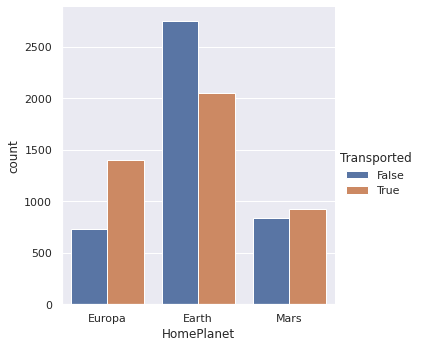

In [15]:
sns.catplot(x = "HomePlanet", data = train_data, hue = 'Transported', kind = 'count')

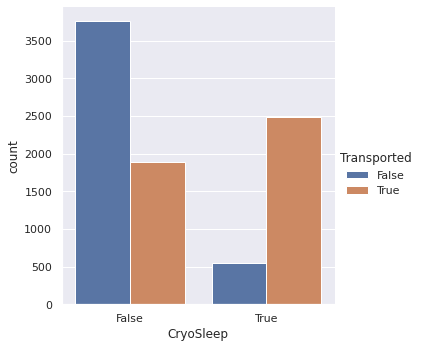

In [16]:
sns.catplot(x = "CryoSleep", data = train_data, hue = 'Transported', kind = 'count')

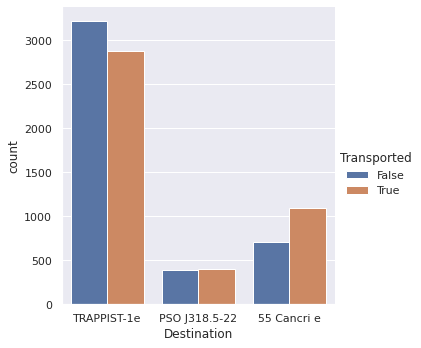

In [17]:
sns.catplot(x = "Destination", data = train_data, hue = 'Transported', kind = 'count')

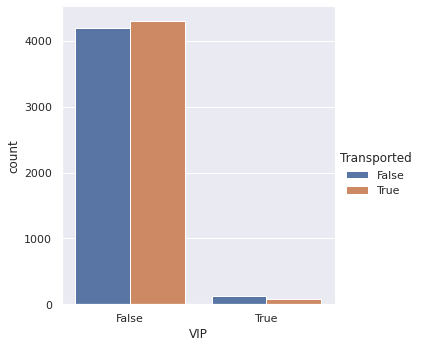

In [18]:
sns.catplot(x = "VIP", data = train_data, hue = 'Transported', kind = 'count')

<AxesSubplot:xlabel='Age', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

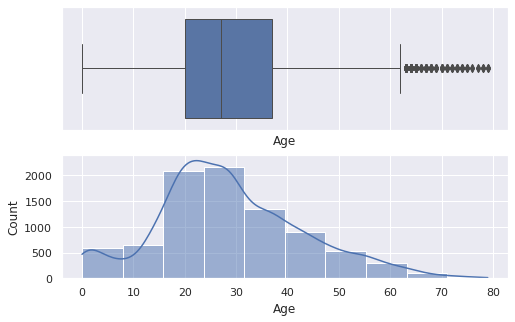

In [19]:
# Age
plt.figure()
plt.tight_layout()
sns.set(rc={"figure.figsize":(8, 5)})
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
plt.gca().set(xlabel= 'Age',ylabel='Count')
sns.boxplot(train_data['Age'], ax=ax_box , linewidth= 1.0)
sns.histplot(train_data['Age'], ax=ax_hist , bins = 10,kde=True)

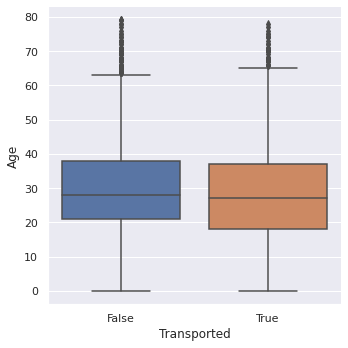

In [20]:
sns.catplot(x= 'Transported', y='Age', data = train_data, kind = 'box')

# **6) Creating New Feature**

Creating new features from two or more existing features can lead to an improvement in the predictive power of a machine learning algorithm. These new features are often referred to as interaction terms.

**6.1) Splitting Cabin Column**

In [21]:
train_data[['Deck','Num','Side']] = train_data['Cabin'].str.split('/', expand = True)
test_data[['Deck','Num','Side']] = test_data['Cabin'].str.split('/', expand = True)

In [22]:
# Dropping Cabin Column
train_data = train_data.drop('Cabin',axis = 1)
test_data = test_data.drop('Cabin', axis =1)

**6.2) Creating Total Expenditure Column**

In [23]:
train_data['Total Expenditure'] = train_data['RoomService'] + train_data['FoodCourt'] + train_data['ShoppingMall'] + train_data['Spa'] + train_data['VRDeck']
test_data['Total Expenditure'] = test_data['RoomService'] + test_data['FoodCourt'] + test_data['ShoppingMall'] + test_data['Spa'] + test_data['VRDeck']

In [24]:
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Total Expenditure
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,0.0
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,736.0
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,10383.0
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,5176.0
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,1091.0


# **7) Preprocessing**

**7.1) Categorical Encoding**

In [25]:
def label_encoder(data):
    colname = ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side','Num']
    label_encoder = LabelEncoder()
    for col in colname:
        data[col]= label_encoder.fit_transform(data[col])

In [26]:
label_encoder(train_data)
label_encoder(test_data)

In [27]:
train_data['Transported'] = train_data['Transported'].replace({True:1,False:0})

In [28]:
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Total Expenditure
PassengerId,,,,,,,,,,,,,,,
0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0
0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,0,1,736.0
0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,0,1,10383.0
0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,1,5176.0
0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1,1,1091.0


**7.2) Data Scaling and Transformations**

Let us now look at the summary statistics of the variables which can be achieved with the line of code below.

In [29]:
train_data.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Total Expenditure
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.649833,0.349362,1.494306,28.827930,0.022892,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,4.344185,960.321063,0.516162,1472.487559
std,0.795183,0.476796,0.814966,14.339054,0.149568,659.739364,1594.434978,597.417440,1124.675871,1133.259049,0.500016,1.775938,506.054595,0.499767,2799.915709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,523.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,1009.000000,1.000000,727.000000
75%,1.000000,1.000000,2.000000,37.000000,0.000000,78.000000,118.000000,45.000000,89.000000,71.000000,1.000000,6.000000,1363.000000,1.000000,1461.000000
max,2.000000,1.000000,2.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,7.000000,1816.000000,1.000000,35987.000000


Most of them have different units and scale, such as 'Age' in years and 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total Expenditure' in dollars. These differences can unduly influence the model and, therefore, we need to scale or transform the features. There are several techniques to achieve this, and some of the popular ones are discussed in the subsequent sections.

**7.2.1) Min-max Scaling**

In this approach, the data is scaled to a fixed range - usually 0 to 1. The impact is that we end up with smaller standard deviations, which can suppress the effect of outliers.

In [30]:
def min_max_scaler(data):
    minmaxscaler = MinMaxScaler() 
    minmaxscaler.fit(data[['Age']]) 
    data['scaled_age'] = minmaxscaler.transform(data[['Age']]) 

In [31]:
min_max_scaler(train_data)
min_max_scaler(test_data)

In [32]:
train_data['scaled_age'].describe()

count    8693.000000
mean        0.364911
std         0.181507
min         0.000000
25%         0.253165
50%         0.341772
75%         0.468354
max         1.000000
Name: scaled_age, dtype: float64

**7.2.2) Standardiztion**

In [33]:
train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total Expenditure']] = StandardScaler().fit_transform(train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total Expenditure']])
print(train_data['RoomService'].var()); print(train_data['FoodCourt'].var()); print(train_data['ShoppingMall'].var()); print(train_data['Spa'].var()); print(train_data['VRDeck'].var()); print(train_data['Total Expenditure'].var())

1.0001150483202943
1.0001150483202947
1.0001150483202945
1.0001150483202943
1.0001150483202947
1.0001150483202945


In [34]:
test_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total Expenditure']] = StandardScaler().fit_transform(test_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total Expenditure']])
print(test_data['RoomService'].var()); print(test_data['FoodCourt'].var()); print(test_data['ShoppingMall'].var()); print(test_data['Spa'].var()); print(test_data['VRDeck'].var()); print(test_data['Total Expenditure'].var())

1.0002338634237604
1.0002338634237606
1.0002338634237604
1.0002338634237604
1.0002338634237604
1.0002338634237602


In [35]:
train_data.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Total Expenditure,scaled_age
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8693.000000,8693.000000,8693.000000,8693.000000,8.693000e+03,8693.000000
mean,0.649833,0.349362,1.494306,28.827930,0.022892,5.987260e-17,7.356361e-17,7.724179e-17,-5.803351e-17,-6.436816e-17,0.503624,4.344185,960.321063,0.516162,7.438098e-17,0.364911
std,0.795183,0.476796,0.814966,14.339054,0.149568,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,0.500016,1.775938,506.054595,0.499767,1.000058e+00,0.181507
min,0.000000,0.000000,0.000000,0.000000,0.000000,-3.405899e-01,-2.873140e-01,-2.908170e-01,-2.766634e-01,-2.690226e-01,0.000000,0.000000,0.000000,0.000000,-5.259345e-01,0.000000
25%,0.000000,0.000000,1.000000,20.000000,0.000000,-3.405899e-01,-2.873140e-01,-2.908170e-01,-2.766634e-01,-2.690226e-01,0.000000,3.000000,523.000000,0.000000,-5.259345e-01,0.253165
50%,0.000000,0.000000,2.000000,27.000000,0.000000,-3.405899e-01,-2.873140e-01,-2.908170e-01,-2.766634e-01,-2.690226e-01,1.000000,5.000000,1009.000000,1.000000,-2.662689e-01,0.341772
75%,1.000000,1.000000,2.000000,37.000000,0.000000,-2.223546e-01,-2.133024e-01,-2.154885e-01,-1.975250e-01,-2.063679e-01,1.000000,6.000000,1363.000000,1.000000,-4.103059e-03,0.468354
max,2.000000,1.000000,2.000000,79.000000,1.000000,2.137681e+01,1.841192e+01,3.903403e+01,1.964845e+01,2.102742e+01,1.000000,7.000000,1816.000000,1.000000,1.232769e+01,1.000000


In [36]:
train_data.corr().style.background_gradient(cmap='coolwarm')

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Total Expenditure,scaled_age
HomePlanet,1.000000,0.083586,0.034737,0.133888,0.123512,0.211527,0.071642,0.101056,0.055014,0.039575,0.115461,-0.404593,0.010726,0.000636,0.150317,0.133888
CryoSleep,0.083586,1.000000,-0.096287,-0.070736,-0.078281,-0.243986,-0.205682,-0.206366,-0.198392,-0.193107,0.460132,0.020613,0.011922,0.023858,-0.376500,-0.070736
Destination,0.034737,-0.096287,1.000000,-0.006619,-0.044707,0.046390,-0.111049,0.024384,-0.055916,-0.073233,-0.108152,0.180763,-0.019041,-0.012979,-0.099205,-0.006619
Age,0.133888,-0.070736,-0.006619,1.000000,0.091574,0.067612,0.127937,0.032655,0.120992,0.099210,-0.074249,-0.239353,-0.000998,0.011758,0.184509,1.000000
VIP,0.123512,-0.078281,-0.044707,0.091574,1.000000,0.056595,0.126006,0.018483,0.060573,0.123092,-0.037261,-0.176063,0.008129,-0.008798,0.163187,0.091574
RoomService,0.211527,-0.243986,0.046390,0.067612,0.056595,1.000000,-0.015521,0.052962,0.009925,-0.019207,-0.242048,-0.021148,0.007059,-0.007503,0.234303,0.067612
FoodCourt,0.071642,-0.205682,-0.111049,0.127937,0.126006,-0.015521,1.000000,-0.013934,0.220587,0.224275,0.046074,-0.315326,0.007150,0.019602,0.742208,0.127937
ShoppingMall,0.101056,-0.206366,0.024384,0.032655,0.018483,0.052962,-0.013934,1.000000,0.013678,-0.007189,0.010019,-0.033470,-0.004077,-0.021922,0.220498,0.032655
Spa,0.055014,-0.198392,-0.055916,0.120992,0.060573,0.009925,0.220587,0.013678,1.000000,0.147957,-0.218791,-0.214997,0.021542,0.005739,0.592439,0.120992
VRDeck,0.039575,-0.193107,-0.073233,0.099210,0.123092,-0.019207,0.224275,-0.007189,0.147957,1.000000,-0.204825,-0.251021,0.004796,-0.008975,0.585835,0.099210


# **8) Modelling**

In [37]:
X = train_data.drop(['Transported','Age','Num'], axis = 1)
y = train_data.loc[:,'Transported']

In [38]:
x_train, x_test, y_train, y_test = TTS(X,y,test_size=0.3, random_state=420)

In [39]:
clr = XGBC(n_estimators=100
           ,eta=0.1
           ,gamma=0
           ,reg_lambda=1
           ,reg_alpha=0
           ,max_depth=3
           ,colsample_bytree=1
           ,colsample_bylevel=1
           ,colsample_bynode=1).fit(x_train,y_train)

pred_y=clr.predict(x_test)
pred=clr.predict(x_train)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_test.values,pred_y))

0.8124897288414134
0.7960122699386503


In [40]:
model=CatBoostClassifier(iterations=1500, eval_metric='Accuracy', verbose=0)
model.fit(x_train,y_train)

pred_y=model.predict(x_test)
pred=model.predict(x_train)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_test.values,pred_y))

0.866885784716516
0.8098159509202454


In [41]:
for col,score in zip(x_train.columns,model.feature_importances_):
    print(col,"-->",score)

HomePlanet --> 9.162400411623983
CryoSleep --> 7.65991357532648
Destination --> 2.577914779931446
VIP --> 0.22095062012880767
RoomService --> 7.166857718988332
FoodCourt --> 7.988343729194481
ShoppingMall --> 5.168767966268873
Spa --> 10.795096622955477
VRDeck --> 9.752105266132306
Deck --> 16.246575781477805
Side --> 4.009721226235291
Total Expenditure --> 12.033200993054269
scaled_age --> 7.218151308682442


In [42]:
y_pred = model.predict(test_data.drop(['Age','Num'], axis = 1))

sub=pd.DataFrame({'Transported':y_pred.astype(bool)},index=test_data.index)

sub.to_csv("submission.csv")